# Generalized Ising with transverse and longitudinal field 

For the sake of studying the effectiveness of a physics guided neural net, we need a generalized Ising description that can generate datasets in arbitrary phases with arbitrary number of sites. In the two site system, the magnetization varies so smoothly across the transition that it is hard to say when the transition actually occurs in the thermodynamic limit.


The energy scale is set by fixing the antiferromagnetic coupling $J = 1$.


The model

$$ H = J \sum_{i=0}^{N-1} \sigma_i^z \sigma_{i+1}^z - B_x \sum_{i=0}^{N-1} \sigma_i^x  - B_z \sum_{i=0}^{N-1} \sigma_i^z $$


The field coefficients are positive always $B_x, B_z \ge 0$, and periodic boundary conditions are used 

The operators are understood to be the $N$-fold product of the spin space

$$ \sigma_i = \mathbf{1} \otimes ... \otimes \sigma \otimes \mathbf{1} ... \otimes \mathbf{1} $$

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import qutip as qu
import sys
import os
import scipy.sparse as sp

In [2]:
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")          # a CUDA device object

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, 10) 

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        return x

net = Net()
print(net)

Net(
  (fc1): Linear(in_features=1, out_features=10, bias=True)
)


In [39]:
params = list(net.parameters())
print(len(params))
print(params[0].size())  # conv1's .weight

2
torch.Size([10, 1])


In [54]:
print(net(torch.randn(1)))

tensor([ 0.3891, -0.1191,  0.3007,  0.1568,  0.5923,  0.3899,  0.2692, -0.1705,
         0.6914,  0.7326], grad_fn=<TanhBackward>)


In [47]:
net.zero_grad()
out = net(torch.randn(1))
out.backward(net(torch.randn(1)))

In [51]:
optimizer = optim.SGD(net.parameters(), lr=0.01)
criterion = nn.MSELoss()
target = torch.randn(10)
# in your training loop:
optimizer.zero_grad()   # zero the gradient buffers
output = net(torch.randn(1))
loss = criterion(output, target)
loss.backward()
optimizer.step()    # Does the update

### Define the functions to construct the energy operator

In [13]:
def transverse(N, site):
    op = []
    
    for i in range(N):
        op.append(qu.qeye(2))
        
    op[site] = qu.sigmax()
    
    return qu.tensor(op)

def longitudinal(N, site):
    op = []
    
    for i in range(N):
        op.append(qu.qeye(2))
        
    op[site] = qu.sigmaz()
    
    return qu.tensor(op)

def coupling(N, site):
    if (site == N-1):
        return longitudinal(N,site) * longitudinal(N, 0)
    else:
        return longitudinal(N,site) * longitudinal(N, site+1)

def H(N, Bx, Bz, J):
    term1 = coupling(N, 0) 
    term2 = transverse(N, 0)
    term3 = longitudinal(N, 0)
       
    for site in range(1, N):
        term1 += coupling(N,site)
        term2 += transverse(N,site)
        term3 += longitudinal(N,site)
    
    return (-J/N) * term1 - (Bx/N) * term2 - (Bz/N) * term3

In [108]:
H(4, 2, 0.01, 1)

Quantum object: dims = [[2, 2, 2, 2], [2, 2, 2, 2]], shape = (16, 16), type = oper, isherm = True
Qobj data =
[[-1.01  -0.5   -0.5    0.    -0.5    0.     0.     0.    -0.5    0.
   0.     0.     0.     0.     0.     0.   ]
 [-0.5   -0.005  0.    -0.5    0.    -0.5    0.     0.     0.    -0.5
   0.     0.     0.     0.     0.     0.   ]
 [-0.5    0.    -0.005 -0.5    0.     0.    -0.5    0.     0.     0.
  -0.5    0.     0.     0.     0.     0.   ]
 [ 0.    -0.5   -0.5    0.     0.     0.     0.    -0.5    0.     0.
   0.    -0.5    0.     0.     0.     0.   ]
 [-0.5    0.     0.     0.    -0.005 -0.5   -0.5    0.     0.     0.
   0.     0.    -0.5    0.     0.     0.   ]
 [ 0.    -0.5    0.     0.    -0.5    1.     0.    -0.5    0.     0.
   0.     0.     0.    -0.5    0.     0.   ]
 [ 0.     0.    -0.5    0.    -0.5    0.     0.    -0.5    0.     0.
   0.     0.     0.     0.    -0.5    0.   ]
 [ 0.     0.     0.    -0.5    0.    -0.5   -0.5    0.005  0.     0.
   0.     0.     0.   

In [196]:
psi = H(4, 0.3, 0.1, 1).groundstate()[1]
#e = np.linalg.eigh( (psi * psi.dag()).full().real )[0]
psi

Quantum object: dims = [[2, 2, 2, 2], [1, 1, 1, 1]], shape = (16, 1), type = ket
Qobj data =
[[0.98964284]
 [0.07099037]
 [0.07099037]
 [0.00972531]
 [0.07099037]
 [0.00514118]
 [0.00972531]
 [0.00172381]
 [0.07099037]
 [0.00972531]
 [0.00514118]
 [0.00172381]
 [0.00972531]
 [0.00172381]
 [0.00172381]
 [0.00233452]]

In [200]:
def reduced_density_matrix(psi):
    num_qubits = int(np.log2(len(psi.full().real)))
    full_dim = len(psi.full().real)
    redu_dim = 2**(int(num_qubits/2))
    
    full_den = (psi * psi.dag()).full().real
    redu_den = np.zeros((redu_dim, redu_dim))
    
    for k in range(redu_dim):
        for l in range(redu_dim):
            for j in range(redu_dim):
                row = (k-0)*redu_dim + j
                col = (l-0)*redu_dim + j
                #print(row, " ", col)
                redu_den[k,l] += full_den[row, col]
    
    return redu_den

reduced_density_matrix(psi)

array([[9.89566791e-01, 7.13272503e-02, 7.13272503e-02, 9.89203131e-03],
       [7.13272503e-02, 5.16361707e-03, 5.14260289e-03, 7.20054297e-04],
       [7.13272503e-02, 5.14260289e-03, 5.16361707e-03, 7.20054297e-04],
       [9.89203131e-03, 7.20054297e-04, 7.20054297e-04, 1.05974570e-04]])

In [201]:
def entanglement_entropy(psi):
    a = np.linalg.eig(reduced_density_matrix(psi))[0]
    return -np.sum(a * np.log(a))

In [130]:
def von_neumann_entropy(psi):
    a = np.linalg.eig( (psi * psi.dag()).full().real )[0]
    return -np.sum(a * np.log(a))

In [202]:
x = np.linspace(0.6,2,50)
y4 = []
for Bx in x:
    psi = H(4, Bx, 0.01, 1).groundstate()[1]
    y4.append(entanglement_entropy(psi))
    
y6 = []
for Bx in x:
    psi = H(6, Bx, 0.01, 1).groundstate()[1]
    y6.append(entanglement_entropy(psi))
    
y8 = []
for Bx in x:
    psi = H(8, Bx, 0.01, 1).groundstate()[1]
    y8.append(entanglement_entropy(psi))

In [203]:
plt.plot(x, y4, label="4 qubits")
plt.plot(x, y6, label="6 qubits")
plt.plot(x, y8, label="8 qubits")
plt.xlabel("Bx")
plt.title("Exact")
plt.legend()
plt.ylabel("Entanglement Entropy")
#plt.axvline(x[np.argmax(y)], ls=":")
#plt.show()
plt.savefig("EE.png", dpi=900, bbox_inches='tight')

In [43]:
N = 12

b2 = H(N, 2, 0.05, 1).eigenstates()[1][0].full().real
b1 = H(N, 0, 0.05, 1).eigenstates()[1][0].full().real
slope = (-b2 - b1)/2 
inter = -b1

def overlap(Bx):
    exact = H(N, Bx, 0.05, 1).eigenstates()[1][0].full().real
    pred = slope * Bx + inter
    pred = pred / np.linalg.norm(pred)
    return abs(pred.T.dot(exact)[0][0])

In [44]:
np.mean([overlap(Bx) for Bx in np.linspace(0,2,10)])

0.7406440450503675

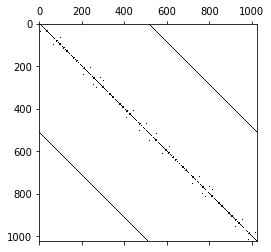

In [5]:
plt.spy(H(10,1,1,1).full())
plt.show()

In [ ]:
def mag(N):
    tmp = longitudinal(N, 0)
    for site in range(1, N):
        tmp += longitudinal(N,site)
    return np.diag(tmp.full().real) / N

## Now define functions returning the parts of the dataset to be written to file

In [ ]:
def BxBz_meshgrid(Bx_min, Bx_max, Bz_min, Bz_max, nBx, nBz):
    
    mat = np.zeros((nBx*nBz, 2), np.float64)

    x = np.linspace(Bx_min, Bx_max, nBx)
    z = np.linspace(Bz_min, Bz_max, nBz)

    c = 0
    for Bx in x:
        for Bz in z:
            mat[c, :] = Bx,Bz
            c += 1
            
    np.random.shuffle(mat)
    
    return mat

In [ ]:
def groundstate_wavefunction_from_qutip(qutip_groundstate_object):
    return qutip_groundstate_object[1].full().real.flatten()

def groundstate_eigenenergy_from_qutip(qutip_groundstate_object):
    return qutip_groundstate_object[0].real

In [ ]:
def values_array_from_qutip_hamiltonian(qutip_hamiltonian):
    tmp = qutip_hamiltonian.full().real
    dim = qutip_hamiltonian.shape[0]
    iu1 = np.triu_indices(dim)
    return tmp[iu1][np.nonzero(tmp[iu1])]
    
def locations_array_from_qutip_hamiltonian(qutip_hamiltonian):
    tmp = qutip_hamiltonian.full().real
    dim = qutip_hamiltonian.shape[0]
    iu1 = np.triu_indices(dim)
    return np.nonzero(tmp[iu1])[0]

In [ ]:
def flattened_hams_gsvecs_and_enes_on_meshgrid(N, J, meshgrid):
    instances = np.size(meshgrid,0)
    dim = 2**N
    nnz = len(values_array_from_qutip_hamiltonian(H(N, 1, 0.01, -1)))
    
    vecs = np.empty((instances, dim), np.float64)
    enes = np.empty((instances, 1), np.float64)
    matval = np.empty((instances, nnz), np.float64)
    matloc = np.empty((instances, nnz), np.int32)
    
    for i in range(instances):  
        ham = H(N, meshgrid[i,0], meshgrid[i,1], J)
        gs = ham.groundstate()
        vecs[i,:] = groundstate_wavefunction_from_qutip(gs)
        enes[i,:] = groundstate_eigenenergy_from_qutip(gs)
        matval[i,:] = values_array_from_qutip_hamiltonian(ham)
        matloc[i,:] = locations_array_from_qutip_hamiltonian(ham)
        
    return matval.flatten(),matloc.flatten(),vecs.flatten(),enes.flatten()

### Solve the eigenproblem in the Bx,Bz plane, manange and write to disk

the function looks long but this is just because the results of the heavy computation are organized and written to various files. This should ultimately save time by writing training data files for several different flavors, as well 
as the priors associated with them. Actually, this is rather necessary so that the shuffled meshgrid is continuous accross seperate files. The nameing convention may need to be tweaked to somehow contain information about the portion of the phase diagram that is sampled by the meshgrid. 

In [ ]:
def write_data(N, J, meshgrid, dir_prefix):
    instances = np.size(meshgrid,0)
    dim = 2**N
    nnz = len(values_array_from_qutip_hamiltonian(H(N, 1, 0.01, -1)))
    
    header = np.array([instances, nnz, dim], np.int32)
    fields = meshgrid[:,0].flatten()
    
    if not os.path.exists(dir_prefix):
        os.makedirs(dir_prefix)
    
    header_path = f"{dir_prefix}header.bin"
    fields_path = f"{dir_prefix}fields.bin"
    matval_path = f"{dir_prefix}matval.bin"
    matloc_path = f"{dir_prefix}matloc.bin"
    wavefx_path = f"{dir_prefix}wavefx.bin"
    energy_path = f"{dir_prefix}energy.bin"

    matval,matloc,wavefx,energy = flattened_hams_gsvecs_and_enes_on_meshgrid(N, J, meshgrid)
    
    with open(header_path, 'wb') as file:
        header.tofile(file)
    
    with open(fields_path, 'wb') as file:
        fields.tofile(file)

    with open(matval_path, 'wb') as file:
        matval.tofile(file)
    
    with open(matloc_path, 'wb') as file:
        matloc.tofile(file)
        
    with open(wavefx_path, 'wb') as file:
        wavefx.tofile(file)
        
    with open(energy_path, 'wb') as file:
        energy.tofile(file)

In [ ]:
J = -1

root = "/home/csingh5/Documents/Guided-Machine-Learning/code/chris/data/input/Ising/"
qubits = [sys.argv[1]]
dsizes = [int(sys.argv[2])]
sampts = ["single-phase/", "dual-phase/"]
splits = ["training/", "validation/", "testing/"]

Bz_min = 0.01; Bz_max = 0.01; nBz = 1; 
Bx_min = 0.01
    
for qubit in qubits:
    for dsize in dsizes:
        for sampt in sampts:
            for split in splits:
                dir_prefix = root + str(qubit) + "-qubits/" + str(dsize) + "k-instances/" + sampt + split
                
                # figure out max transverse field 
                if sampt == "dual-phase/" or split == "testing/":
                    Bx_max = 2
                else:
                    Bx_max = 0.5
                
                # figure out number of instances 
                if split == "training/":
                    nBx = dsize * 700
                elif split == "validation/":
                    nBx = dsize * 200
                else:
                    nBx = dsize * 100
                    
                grid = BxBz_meshgrid(Bx_min, Bx_max, Bz_min, Bz_max, nBx, nBz)
                write_data(int(qubit), J, grid, dir_prefix)
                print("finished:", dir_prefix, nBx)